<a href="https://colab.research.google.com/github/eddiechn/Multi-Class-Animal-Classification/blob/main/Multi_Animal_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
ad23274e4c18b2822f27b09300d81ae6

In [1]:
# import libraries - data science
import numpy as np
import pandas as pd
import tensorflow as tf
import random


# import libraries - visualization
import matplotlib.pyplot as plt

# import libraries - system
import os
from pathlib import Path


In [2]:
!pip install opendatasets

In [3]:
# data
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [4]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/alessiocorrado99/animals10/data?select=raw-img')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: eddiechn1
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10


100%|██████████| 586M/586M [00:07<00:00, 79.4MB/s]


In [5]:
import sys
sys.path.append('/content/animals10') ## sys.path list of directories to look at when import is invoked

sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/animals10']

In [6]:
from translate import translate
print(translate)

{'cane': 'dog', 'cavallo': 'horse', 'elefante': 'elephant', 'farfalla': 'butterfly', 'gallina': 'chicken', 'gatto': 'cat', 'mucca': 'cow', 'pecora': 'sheep', 'scoiattolo': 'squirrel', 'dog': 'cane', 'elephant': 'elefante', 'butterfly': 'farfalla', 'chicken': 'gallina', 'cat': 'gatto', 'cow': 'mucca', 'spider': 'ragno', 'squirrel': 'scoiattolo'}


In [7]:
dataset_dir = 'animals10/raw-img'

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE,
    label_mode='int'
)

Found 26179 files belonging to 10 classes.


In [9]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

In [11]:
directory = Path(dataset_dir)
for animal in directory.iterdir():
  if animal.is_dir():
    for img in animal.iterdir():
      try:
          PIL.Image.open(img)
      except UnidentifiedImageError:
          os.remove(img)
          print(f"Removed {img}")

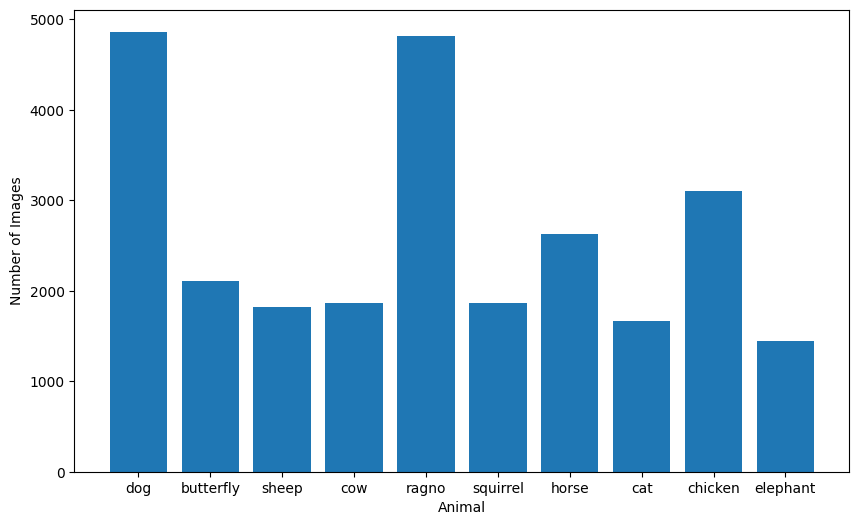

In [12]:
# distrbution
image_counts = {}
for animal in directory.iterdir():
  if animal.is_dir():
    image_counts[animal.name] = len(list(animal.iterdir()))

labels = [translate.get(animal, animal) for animal in image_counts.keys()]

plt.figure(figsize=(10, 6))
plt.bar(labels, image_counts.values())
plt.xlabel('Animal')
plt.ylabel('Number of Images')
plt.show()

In [13]:
def get_random_animal(dataset, num_images):
    all_images = []
    all_labels = []
    for images, labels in dataset.take(10):
        all_images.extend(images.numpy())  # Convert tensors to numpy arrays
        all_labels.extend(labels.numpy())  # Convert tensors to numpy arrays

    random_indices = np.random.choice(len(all_images), num_images, replace=False)
    selected_images = [all_images[i] for i in random_indices]
    selected_labels = [all_labels[i] for i in random_indices]

    return selected_images, selected_labels

In [14]:
label_mapping = {
    0: 'dog',
    1: 'horse',
    2: 'elephant',
    3: 'butterfly',
    4: 'chicken',
    5: 'cat',
    6: 'cow',
    7: 'sheep',
    8: 'spider',
    9: 'squirrel'
}

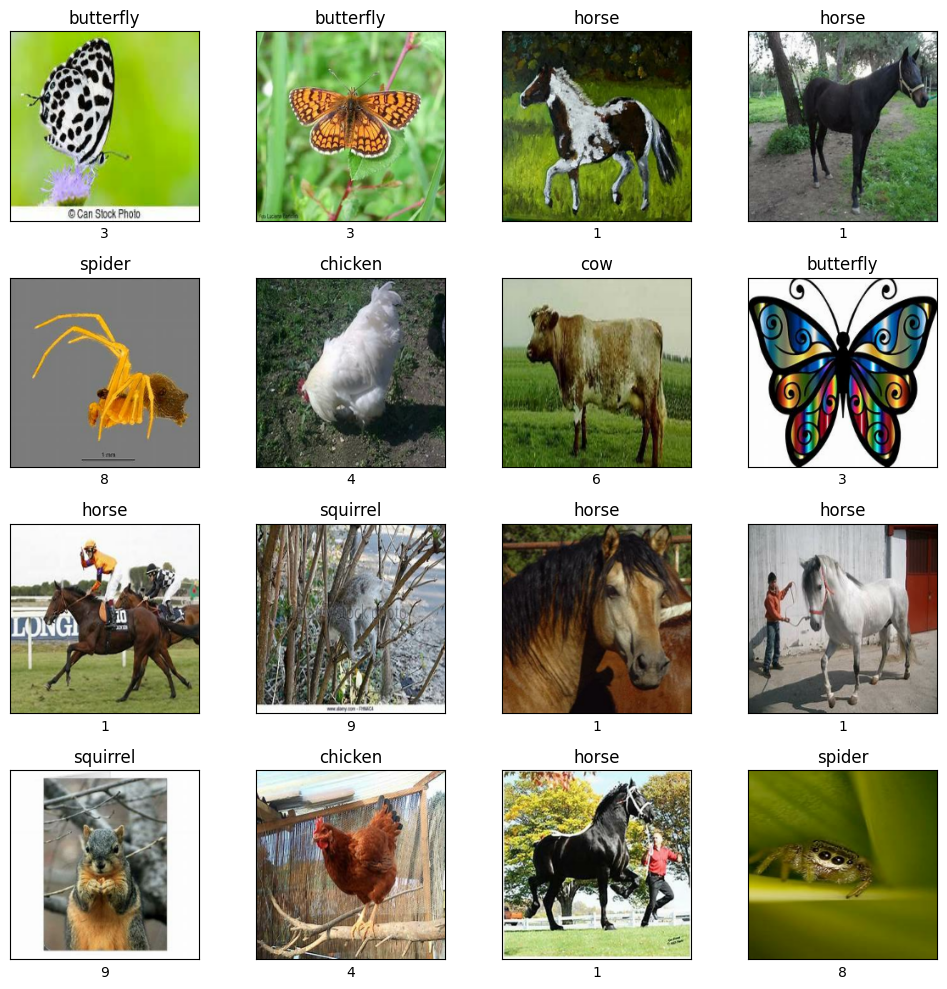

In [17]:
images, labels = get_random_animal(dataset, 16)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].astype('int'))
    ax.set_title(label_mapping[labels[i]])
    ax.set_xlabel(labels[i])

plt.tight_layout()
plt.show()

Preprocessing

In [15]:
VALIDATION_SPLIT = 0.2  # 20% of data for validation
TEST_SPLIT = 0.1  # 10% of data for testing (from the original dataset)

In [19]:
tf.data.experimental.cardinality(dataset).numpy()

819

In [16]:
def split_dataset(dataset, val_split=0.2, test_split=0.1, seed=42):
    # Calculate split sizes
    train_size = int(tf.data.experimental.cardinality(dataset).numpy()  * (1 - (val_split + test_split)))
    val_size = int(tf.data.experimental.cardinality(dataset).numpy() * val_split)
    test_size = int(tf.data.experimental.cardinality(dataset).numpy() * test_split)


    print(f"Train size: {train_size}")
    print(f"Validation size: {val_size}")
    print(f"Test size: {test_size}")

    # Split the dataset
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size).take(test_size)

    return train_dataset, val_dataset, test_dataset


In [17]:
train_dataset, val_dataset, test_dataset = split_dataset(dataset)

Train size: 573
Validation size: 163
Test size: 81


In [18]:
tf.data.experimental.cardinality(dataset)

<tf.Tensor: shape=(), dtype=int64, numpy=819>

In [19]:
# automatic tuning of some parameters. prefetching. improves performance

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [24]:
for images, labels in train_dataset:
    print(f"Train images shape: {images.shape}")
    print(f"Train labels shape: {labels.shape}")
    break

Train images shape: (32, 224, 224, 3)
Train labels shape: (32,)


Train the model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Rescaling, Dropout, BatchNormalization

In [21]:
num_classes = 10
IMG_SIZE = (224, 224)

In [22]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

258076736/258076736 [==============================] - 3s 0us/step


In [23]:
# defining callback functions
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='auto',
    patience=3,
    verbose=0,
    restore_best_weights=True
)



In [26]:
input = pretrained_model.input

x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)

output = Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=input, outputs=output)

In [27]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [29]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
hist = model.fit(train_dataset,
                 epochs=10,
                 validation_data=val_dataset,
                 callbacks=[tensorboard_callback, early_stopping])

Epoch 1/25
573/573 [==============================] - 314s 498ms/step - loss: 0.3399 - accuracy: 0.9037 - val_loss: 0.1504 - val_accuracy: 0.9595
Epoch 2/25
573/573 [==============================] - 281s 489ms/step - loss: 0.1868 - accuracy: 0.9485 - val_loss: 0.1450 - val_accuracy: 0.9611
Epoch 3/25
573/573 [==============================] - 283s 493ms/step - loss: 0.1642 - accuracy: 0.9554 - val_loss: 0.1342 - val_accuracy: 0.9672
Epoch 4/25
573/573 [==============================] - 287s 500ms/step - loss: 0.1570 - accuracy: 0.9552 - val_loss: 0.1241 - val_accuracy: 0.9688
Epoch 5/25
573/573 [==============================] - 287s 500ms/step - loss: 0.1326 - accuracy: 0.9630 - val_loss: 0.1584 - val_accuracy: 0.9594
Epoch 6/25
573/573 [==============================] - 279s 487ms/step - loss: 0.1326 - accuracy: 0.9632 - val_loss: 0.1374 - val_accuracy: 0.9676
Epoch 7/25
573/573 [==============================] - 281s 489ms/step - loss: 0.1403 - accuracy: 0.9596 - val_loss: 0.1179 -

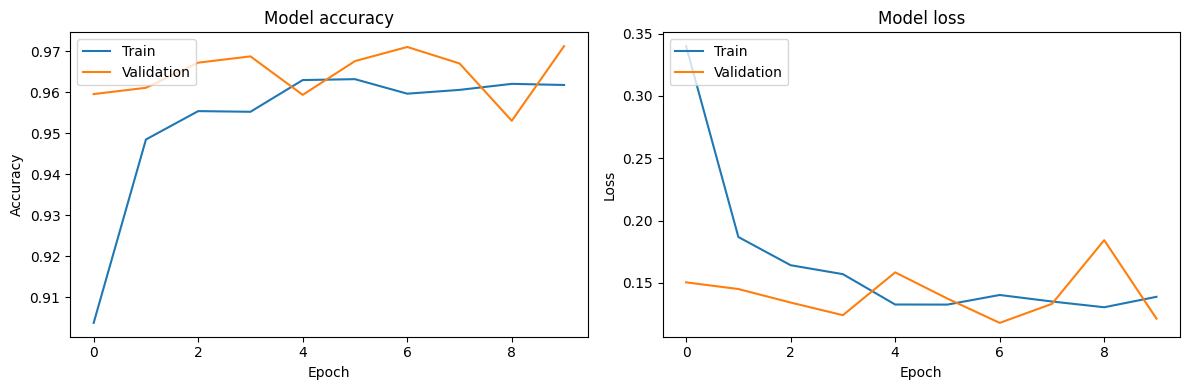

In [46]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

##Evaluating Model

In [32]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [36]:
results = model.evaluate(test_dataset, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.12918
Test Accuracy: 97.18%


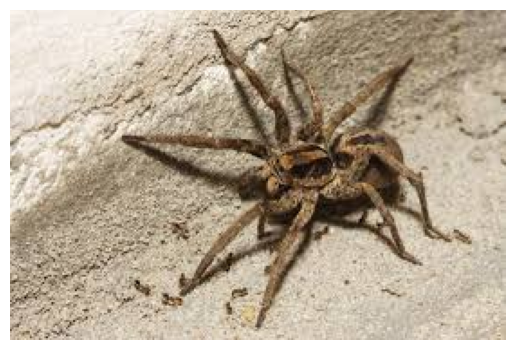

In [51]:
import cv2

img = cv2.imread('spider.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)
plt.show()

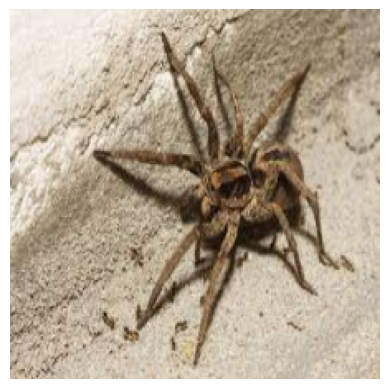

In [52]:
resized = tf.image.resize(img, (224, 224))
plt.imshow(resized.numpy().astype(int))
plt.axis('off')
plt.show()

#Save Model

In [37]:
from tensorflow.keras.models import load_model

In [38]:
model.save(os.path.join('models', 'animal_classifier.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
model2 = load_model(os.path.join('models', 'animal_classifier.h5'))

In [40]:
model2